In [2]:
import os
import sys
import glob
import collections
import pandas as pd

In [3]:
VIDEO_FOLDER = "/media/data_cifs/nih/files_to_send/"
ACTION_FOLDER = "/media/data_cifs/nih/inference/results_csv/"

In [4]:
def cohort_search(cohort, search_root, ret=False):
    cohort = str(cohort).upper()
    all_folders = [folder for folder in os.listdir(search_root) if folder.startswith("FC-"+cohort)]
    all_folders.sort()
    all_folder_list = "\n".join(all_folders)
    if ret:
        return all_folders
    else:
        print(all_folder_list)

In [5]:
def find_mouse_videos(mouse_id, cohort, ret=False):
    
    search_for = "v"
    
    if search_for == "videos":
        print("Looking for videos..")
        file_extension = ".mp4" 
        ROOT_FOLDER = VIDEO_FOLDER
    else:
        print("Looking for actions...")
        file_extension = ".csv"
        ROOT_FOLDER = ACTION_FOLDER
    
    mouse_id = str(mouse_id)
    cohort_folders = cohort_search(cohort, ROOT_FOLDER, ret=True)
    
    preexposure_folders = [folder for folder in cohort_folders if "exp" in folder]
    postcond_folders = [folder for folder in cohort_folders if "cond" in folder]
    postext_folders = [folder for folder in cohort_folders if "xt" in folder]
    postret_folders = [folder for folder in cohort_folders if "tre" in folder]
    
    preexposure_videos = []
    postcond_videos = []
    postext_videos = []
    postret_videos = []
    
    for folder in preexposure_folders:
        preexposure_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    preexposure_videos.sort()
    
    for folder in postcond_folders:
        postcond_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postcond_videos.sort()
    
    for folder in postext_folders:
        postext_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postext_videos.sort()
    
    for folder in postret_folders:
        postret_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postret_videos.sort()
    
    if ret:
        return preexposure_videos, postcond_videos
    else:
        print("\nPREEXPOSURE:")
        print("\n".join(preexposure_videos))
        print("\nPOSTCONDITIONING:")
        print("\n".join(postcond_videos))
        print("\nPOSTEXTINCTION:")
        print("\n".join(postext_videos))
        print("\nPOSTRETRIEVAL:")
        print("\n".join(postret_videos))
    
    

In [10]:
find_mouse_videos(2338, "A")

Looking for actions...

PREEXPOSURE:
video_2018Y_08M_07D_09h_51m_01s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_10h_51m_01s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_11h_51m_01s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_12h_51m_02s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_13h_51m_02s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_14h_51m_03s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_15h_51m_03s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_16h_51m_03s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_20h_13m_13s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_21h_13m_13s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_22h_13m_13s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
video_2018Y_08M_07D_23h_13m_13s_cam_17202338-0000.csv/FC-A_08-07-18_preexposure
vid

In [109]:
BEH_LABELS = ['drink', 'eat', 'groom', 'hang', 'sniff', 'rear', 'rest', 'walk', 'eathand']
action_colours = ['tab:blue', 'tab:orange', 'limegreen', 'deepskyblue', 'tab:pink', 'tab:purple', 'tab:brown', 'red', 'black']
len(action_colours) == len(BEH_LABELS)

True

In [275]:
def pre_and_postcondition_interval(mouse_id, cohort, hour, period, ret=False):
    '''
    Return the starting and ending video
    '''
    
    hour = int(hour)
    period = int(period)
    
    pre_videos, post_videos = find_mouse_videos(mouse_id, cohort, ret=True)
    
    hour_pre_videos = []
    hour_post_videos = []
    
    hour_start_string = str(hour).zfill(2) + 'h'
    hour_end_string = str(hour + period).zfill(2) + 'h'
    
    for start_video in pre_videos:
        if hour_start_string in start_video:
            hour_set = []
            day = start_video.split("D")
            day = day[0][-2:] + "D"
            new_hour = hour
            while new_hour < hour + period:
                hour_string = str(new_hour).zfill(2) + 'h'
                
                for end_video in pre_videos:
                    if hour_string in end_video and day in end_video:
                        hour_set.append(end_video)
                if new_hour != 23:
                    new_hour = new_hour + 1
                else:
                    new_hour = 0
                    day = str(int(day[0:-1]) + 1).zfill(2)+'D'
            hour_pre_videos.append(hour_set)
    
    for start_video in post_videos:
        if hour_start_string in start_video:
            hour_set = []
            day = start_video.split("D")
            day = day[0][-2:] + "D"
            new_hour = hour
            while new_hour < hour + period:
                hour_string = str(new_hour).zfill(2) + 'h'
                
                for end_video in post_videos:
                    if hour_string in end_video and day in end_video:
                        hour_set.append(end_video)
                if new_hour != 23:
                    new_hour = new_hour + 1
                else:
                    new_hour = 0
                    day = str(int(day[0:-1]) + 1).zfill(2)+'D'
            hour_post_videos.append(hour_set)
    
    if ret:
        return hour_pre_videos, hour_post_videos
    else:
        print("\nPREEXPOSURE VIDEOS:")
        for video_set in hour_pre_videos:
            for video in video_set:
                print(video)
            print()
        print("\nPOSTCONDITIONING VIDEOS:")
        for video in hour_post_videos:
            for video in video_set:
                print(video)
            print()

In [308]:
# READING THE CSV: postcond2_actions[0].iloc[2][1]
# Loading actions
# 17202338:
preexposure_actions_17202338_a = []
postcond_actions_17202338_a = []
postext_actions_17202338_a = []
postret_actions_17202338_a = []

preexposure_video_list_17202338_a = ["video_2018Y_08M_10D_23h_56m_27s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_00h_56m_27s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_01h_56m_28s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_02h_56m_28s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_03h_56m_28s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_04h_56m_28s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_05h_56m_28s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_06h_56m_29s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_07h_56m_29s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_09h_56m_29s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_10h_56m_29s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_11h_56m_30s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_12h_56m_30s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_13h_56m_30s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_14h_56m_30s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_15h_56m_31s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_16h_56m_31s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_17h_56m_31s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_18h_56m_31s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_19h_56m_31s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_20h_56m_32s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_21h_56m_32s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_22h_56m_32s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_11D_23h_56m_32s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_00h_56m_32s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_01h_56m_33s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_02h_56m_33s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_03h_56m_34s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_04h_56m_34s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_05h_56m_34s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_06h_56m_34s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
"video_2018Y_08M_12D_07h_56m_35s_cam_17202338-0000.csv/FC-A_08-09-18_preexposure",
]


for action_list in preexposure_video_list_17202338_a:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    preexposure_actions_17202338_a.append(actions)

print("Preexposure Files:", len(preexposure_actions_17202338_a))

postcond_video_list_17202338_a = ["video_2018Y_08M_13D_23h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_00h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_01h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_02h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_03h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_04h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_05h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_06h_21m_05s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_07h_21m_06s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_09h_28m_54s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_10h_28m_55s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_11h_28m_55s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_12h_28m_56s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_13h_28m_56s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_14h_28m_56s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_15h_28m_57s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_16h_28m_57s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_17h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_18h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_19h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_20h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_21h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_22h_28m_58s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_14D_23h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_00h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_01h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_02h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_03h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_04h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_05h_28m_59s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_06h_29m_00s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
"video_2018Y_08M_15D_07h_29m_00s_cam_17202338-0000.csv/FC-A_08-10-18_postcond",
]

for action_list in postcond_video_list_17202338_a:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    postcond_actions_17202338_a.append(actions)
print("Postcond Files:", len(postcond_actions_17202338_a))
    
postext_video_list_17202338_a = ["video_2018Y_08M_15D_23h_58m_47s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_00h_58m_47s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_01h_58m_47s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_02h_58m_48s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_03h_58m_49s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_04h_58m_49s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_05h_58m_49s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_06h_58m_49s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_07h_58m_49s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_09h_09m_52s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_10h_09m_54s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_11h_09m_54s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_12h_09m_56s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_13h_09m_56s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_14h_09m_57s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_15h_09m_57s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_16h_09m_57s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_17h_09m_57s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_18h_09m_58s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_19h_09m_58s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_20h_09m_58s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_21h_09m_59s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_22h_09m_59s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_16D_23h_09m_59s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_00h_09m_59s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_01h_10m_00s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_02h_10m_00s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_03h_10m_00s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_04h_10m_00s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_05h_10m_01s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_06h_10m_01s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
"video_2018Y_08M_17D_07h_10m_01s_cam_17202338-0000.csv/FC-A_08-15-18_postext",
]

for action_list in postext_video_list_17202338_a:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    postext_actions_17202338_a.append(actions)

print("Postext Files:", len(postext_actions_17202338_a))

postret_video_list_17202338_a = ["video_2018Y_08M_20D_22h_54m_36s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_20D_23h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_00h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_01h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_02h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_03h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_04h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_05h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_06h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_07h_54m_37s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_08h_54m_38s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_09h_54m_38s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_10h_54m_38s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_11h_54m_38s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_12h_54m_38s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_13h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_14h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_15h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_16h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_17h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_18h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_19h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_20h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_21h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_22h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_21D_23h_54m_39s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_00h_54m_40s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_01h_54m_40s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_02h_54m_41s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_03h_54m_41s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_04h_54m_41s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
"video_2018Y_08M_22D_05h_54m_41s_cam_17202338-0000.csv/FC-A_08-20-18_postret",
]

for action_list in postret_video_list_17202338_a:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    postret_actions_17202338_a.append(actions)

print("Postret Files:", len(postret_actions_17202338_a))

Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_10D_23h_56m_27s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_00h_56m_27s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_01h_56m_28s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_02h_56m_28s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_03h_56m_28s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_04h_56m_28s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-09-18_preexposure/video_2018Y_08M_11D_05h_56m_28s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/resu

Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-10-18_postcond/video_2018Y_08M_15D_05h_28m_59s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-10-18_postcond/video_2018Y_08M_15D_06h_29m_00s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-10-18_postcond/video_2018Y_08M_15D_07h_29m_00s_cam_17202338-0000.csv
Postcond Files: 32
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-15-18_postext/video_2018Y_08M_15D_23h_58m_47s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-15-18_postext/video_2018Y_08M_16D_00h_58m_47s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-15-18_postext/video_2018Y_08M_16D_01h_58m_47s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-15-18_postext/video_2018Y_08M_16D_02h_58m_48s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_cs

Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-20-18_postret/video_2018Y_08M_22D_02h_54m_41s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-20-18_postret/video_2018Y_08M_22D_03h_54m_41s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-20-18_postret/video_2018Y_08M_22D_04h_54m_41s_cam_17202338-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-A_08-20-18_postret/video_2018Y_08M_22D_05h_54m_41s_cam_17202338-0000.csv
Postret Files: 32


In [309]:
all_preexposure_actions_17202338_a = []
for action_set in preexposure_actions_17202338_a:
    for idx in range(len(action_set)):
        all_preexposure_actions_17202338_a.append(action_set.iloc[idx][1])
print("Preexposure:", len(all_preexposure_actions_17202338_a))

all_postcond_actions_17202338_a = []
for action_set in postcond_actions_17202338_a:
    for idx in range(len(action_set)):
        all_postcond_actions_17202338_a.append(action_set.iloc[idx][1])
print("Postcond:", len(all_postcond_actions_17202338_a))

all_postext_actions_17202338_a = []
for action_set in postext_actions_17202338_a:
    for idx in range(len(action_set)):
        all_postext_actions_17202338_a.append(action_set.iloc[idx][1])
print("Postext:", len(all_postext_actions_17202338_a))

all_postret_actions_17202338_a = []
for action_set in postret_actions_17202338_a:
    for idx in range(len(action_set)):
        all_postret_actions_17202338_a.append(action_set.iloc[idx][1])
print("Postret:", len(all_postret_actions_17202338_a))

Preexposure: 3450848
Postcond: 3450848
Postext: 3450848
Postret: 3450848


In [280]:
# READING THE CSV: postcond2_actions[0].iloc[2][1]
# Loading actions
# 4840:
preexposure_actions_6394840_d = []
postcond1_actions_6394840_d = []
postcond2_actions_6394840_d = []

preexposure_video_list_6394840_d = ["video_2019Y_06M_04D_16h_14m_44s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_17h_14m_45s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_18h_14m_46s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_19h_14m_47s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_20h_14m_53s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_21h_14m_55s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_22h_14m_56s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_04D_23h_15m_00s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_00h_15m_01s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_01h_15m_02s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_02h_15m_03s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_03h_15m_08s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_04h_15m_09s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_05h_15m_14s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_06h_15m_17s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_07h_15m_18s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_08h_15m_19s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_09h_15m_20s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_10h_15m_21s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_11h_15m_22s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-04-2019_comp2",
"video_2019Y_06M_05D_12h_23m_02s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_13h_23m_04s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_14h_23m_05s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_15h_23m_08s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_16h_23m_12s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_17h_23m_13s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_18h_23m_17s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_19h_23m_20s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_20h_23m_22s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_21h_23m_24s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_22h_23m_25s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_05D_23h_23m_26s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_00h_23m_28s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_01h_23m_31s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_02h_23m_35s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_03h_23m_38s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_04h_23m_42s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_05h_23m_47s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_06h_23m_48s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
"video_2019Y_06M_06D_07h_23m_50s_cam_6394840-0000.csv/FC-D_preexposure_W1_06-05-2019_comp2",
]


for action_list in preexposure_video_list_6394840_d:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    preexposure_actions_6394840_d.append(actions)

print("Preexposure Files:", len(preexposure_actions_6394840_d))

postcond_video_list1_6394840_d = ["video_2019Y_06M_06D_12h_13m_35s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_13h_13m_39s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_14h_13m_42s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_15h_13m_44s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_16h_13m_50s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_17h_13m_50s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_18h_13m_56s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_19h_14m_02s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_20h_14m_02s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_21h_14m_03s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_22h_14m_05s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_06D_23h_14m_08s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_00h_14m_11s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_01h_14m_14s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_02h_14m_14s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_03h_14m_15s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_04h_14m_17s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_05h_14m_18s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_06h_14m_21s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_07h_14m_21s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_08h_14m_24s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_09h_14m_26s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_10h_14m_27s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_11h_14m_27s_cam_6394840-0000.csv/FC-D_postcond_W2_06-06-2019_comp2",
"video_2019Y_06M_07D_13h_23m_06s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_14h_23m_10s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_15h_23m_13s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_16h_23m_15s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_17h_23m_18s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_18h_23m_23s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_19h_23m_24s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_20h_23m_24s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_21h_23m_29s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_22h_23m_30s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_07D_23h_23m_31s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_08D_00h_23m_31s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_08D_01h_23m_33s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_08D_02h_23m_36s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_08D_03h_23m_38s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
"video_2019Y_06M_08D_04h_23m_39s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2",
]

for action_list in postcond_video_list1_6394840_d:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    postcond1_actions_6394840_d.append(actions)
print("Postcond 1 Files:", len(postcond1_actions_6394840_d))
    
postcond_video_list2_6394840_d = ["video_2019Y_06M_08D_02h_23m_36s_cam_6394840-0000.csv/FC-D_postcond_W2_06-07-2019_comp2"]

for action_list in postcond_video_list2_6394840_d:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    print("Reading CSV:", csv_name)
    postcond2_actions_6394840_d.append(actions)

print("Postcond 2 Files:", len(postcond2_actions_6394840_d))

Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_16h_14m_44s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_17h_14m_45s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_18h_14m_46s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_19h_14m_47s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_20h_14m_53s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_21h_14m_55s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_preexposure_W1_06-04-2019_comp2/video_2019Y_06M_04D_22h_14m_56s

Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_05h_14m_18s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_06h_14m_21s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_07h_14m_21s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_08h_14m_24s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_09h_14m_26s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_10h_14m_27s_cam_6394840-0000.csv
Reading CSV: /media/data_cifs/nih/inference/results_csv/FC-D_postcond_W2_06-06-2019_comp2/video_2019Y_06M_07D_11h_14m_27s_cam_6394840-0000.csv

In [281]:
all_preexposure_actions_6394840_d = []
for action_set in preexposure_actions_6394840_d:
    for idx in range(len(action_set)):
        all_preexposure_actions_6394840_d.append(action_set.iloc[idx][1])
print("Preexposure:", len(all_preexposure_actions_6394840_d))

all_postcond1_actions_6394840_d = []
for action_set in postcond1_actions_6394840_d:
    for idx in range(len(action_set)):
        all_postcond1_actions_6394840_d.append(action_set.iloc[idx][1])
print("Postcond1:", len(all_postcond1_actions_6394840_d))

all_postcond2_actions_6394840_d = []
for action_set in postcond2_actions_6394840_d:
    for idx in range(len(action_set)):
        all_postcond2_actions_6394840_d.append(action_set.iloc[idx][1])
print("Postcond2:", len(all_postcond2_actions_6394840_d))

Preexposure: 4313560
Postcond1: 4313560
Postcond2: 107839


# Visualization

In [302]:
counter2 = collections.Counter(all_postcond2_actions_17202338_a)
counter1 = collections.Counter(all_postcond1_actions_17202338_a)
counter0 = collections.Counter(all_preexposure_actions_17202338_a)

preexposure_17202338_a = [counter0[x] for x in sorted(counter0.keys())]
postcond1_17202338_a = [counter1[x] for x in sorted(counter1.keys())]
postcond2_17202338_a = [counter2[x] for x in sorted(counter2.keys())]

In [282]:
counter2 = collections.Counter(all_postcond2_actions_6394840_d)
counter1 = collections.Counter(all_postcond1_actions_6394840_d)
counter0 = collections.Counter(all_preexposure_actions_6394840_d)

preexposure_6394840_d = [counter0[x] for x in sorted(counter0.keys())]
postcond1_6394840_d = [counter1[x] for x in sorted(counter1.keys())]
postcond2_6394840_d = [counter2[x] for x in sorted(counter2.keys())]

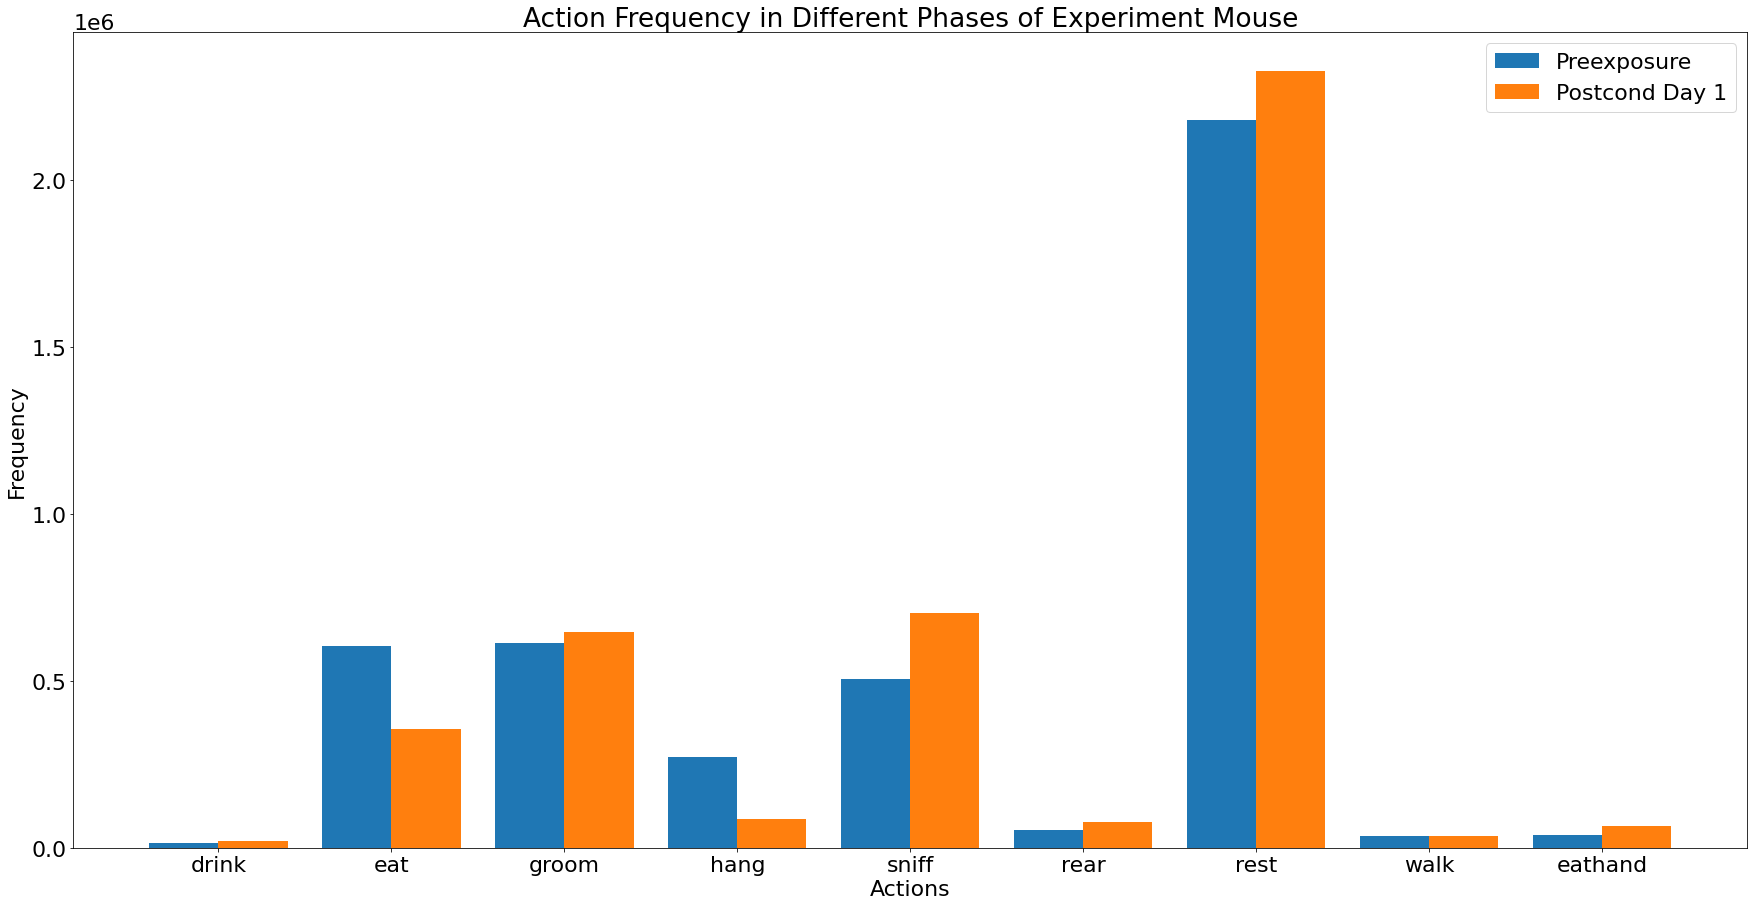

In [304]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = [BEH_LABELS[i] for i in range(0,9)]

X_axis = np.arange(len(X))

plt.figure(figsize=(30, 15))
plt.rcParams.update({'font.size': 22})
plt.bar(X_axis - 0.2, preexposure_17202338_a, 0.4, label = 'Preexposure')
plt.bar(X_axis + 0.2 , postcond1_17202338_a , 0.4, label = 'Postcond Day 1')


plt.xticks(X_axis, X)
plt.xlabel("Actions")
plt.ylabel("Frequency")
plt.title("Action Frequency in Different Phases of Experiment Mouse")
plt.legend()
plt.show()

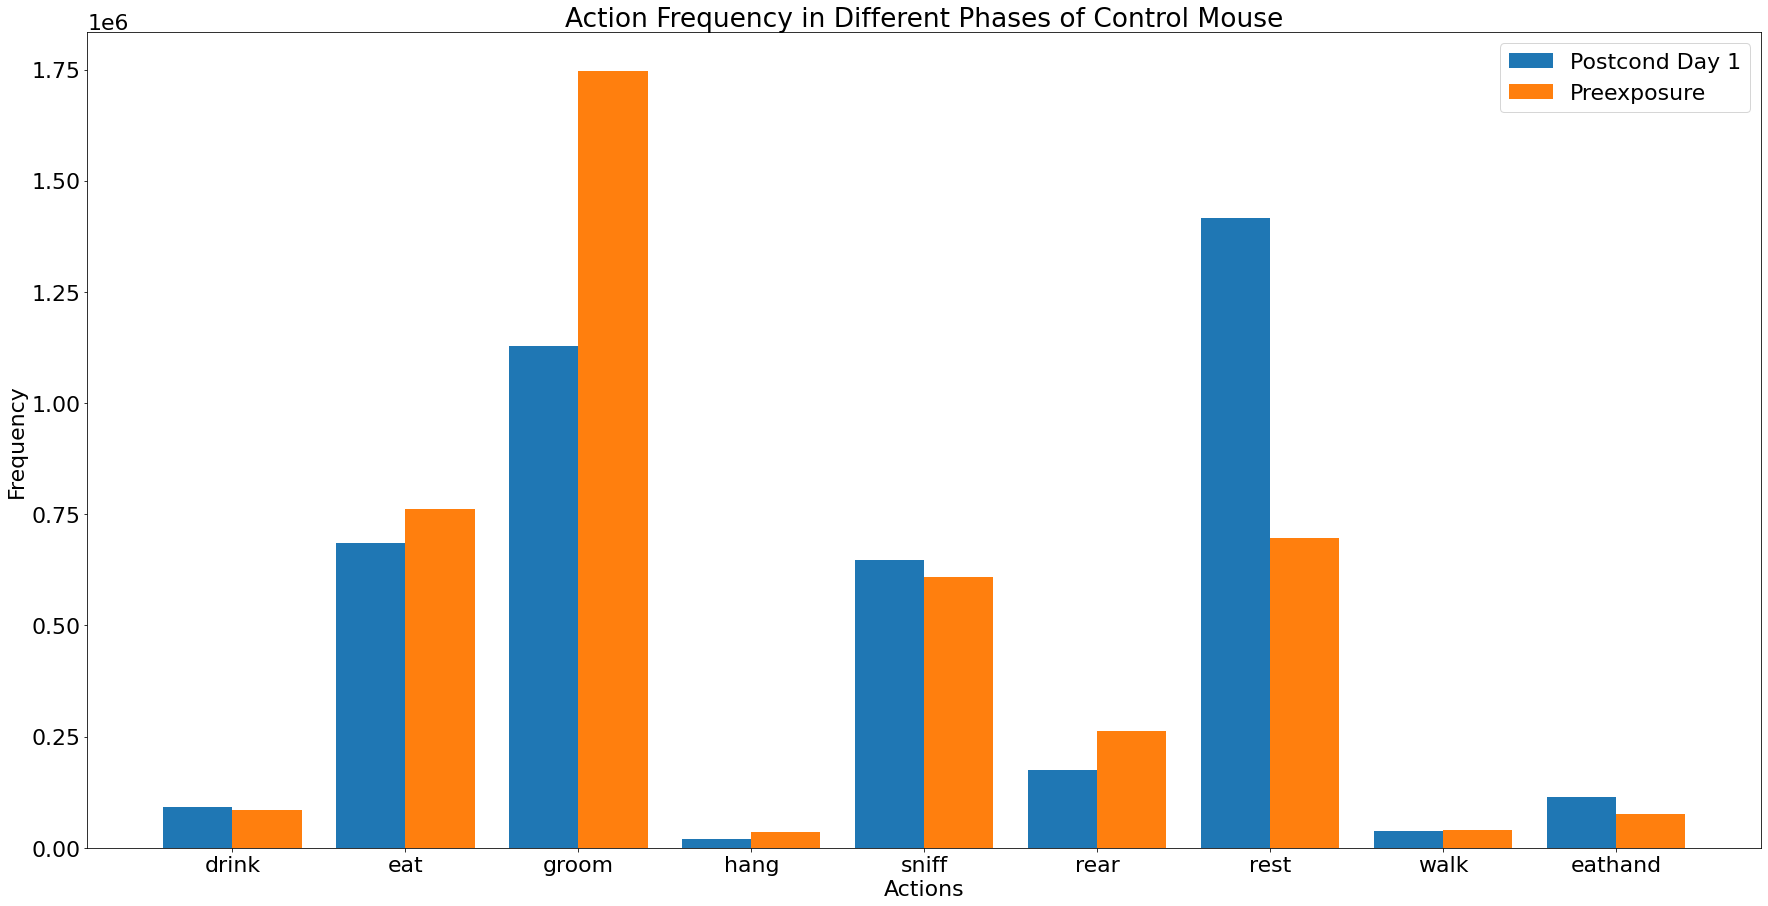

In [305]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = [BEH_LABELS[i] for i in range(0,9)]

X_axis = np.arange(len(X))

plt.figure(figsize=(30, 15))
plt.rcParams.update({'font.size': 22})
# plt.bar(X_axis + 0.3, postcond2_6394840_d, 0.3, label = 'Postcond Day 2')
plt.bar(X_axis - 0.2, postcond1_6394840_d, 0.4, label = 'Postcond Day 1')
plt.bar(X_axis + 0.2, preexposure_6394840_d, 0.4, label = 'Preexposure')

plt.xticks(X_axis, X)
plt.xlabel("Actions")
plt.ylabel("Frequency")
plt.title("Action Frequency in Different Phases of Control Mouse")
plt.legend()
plt.show()